# Bubble wall velocity under LTE

In [1]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt
import plotter as pl
from helperFunctions import derivative, alpha_p, cs_sq, dYdtau, dvTdxi, r_func, μ, w

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Sech = lambda x: 1/np.cosh(x)
Tanh = np.tanh
ArcSin = np.arcsin
ArcTanh = np.arctanh
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)


def Plot(fun, xminmax, n=100,xfun=np.linspace, xlog=False, ylog=False):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

## Prepare

Import model

In [2]:
import SM_model as m

In [3]:
mod = m.SM(1,0.007285228,636.8644639563023)

Model inialized.
g2 = 1
λ = 0.007285228
μh = 25.236173718618723


In [4]:
mod.findTc()
mod.findTn()

Finding Tc...
Critical temperature found! Tc = 56.636213599704206
v_c/Tc = 2.805112061801922
Finding Tn...
Tunneling at T = 56.6162135997042
S3/T = 1776610.821118072
Tunneling at T = 56.5962135997042
S3/T = 451853.48759337695
Tunneling at T = 56.576213599704204
S3/T = 203892.6206760976
Tunneling at T = 56.5562135997042
S3/T = 116379.02610579527
Tunneling at T = 56.536213599704205
S3/T = 75553.78881274353
Tunneling at T = 56.5162135997042
S3/T = 53207.225980410876
Tunneling at T = 56.496213599704205
S3/T = 39631.40596042085
Tunneling at T = 56.4762135997042
S3/T = 30754.56578884889
Tunneling at T = 56.456213599704206
S3/T = 24623.812731046
Tunneling at T = 56.4362135997042
S3/T = 20206.5170962416
Tunneling at T = 56.4162135997042
S3/T = 16914.527920606317
Tunneling at T = 56.396213599704204
S3/T = 14392.707450128244
Tunneling at T = 56.3762135997042
S3/T = 12416.149901957511
Tunneling at T = 56.356213599704205
S3/T = 10836.688219983376
Tunneling at T = 56.3362135997042
S3/T = 9553.51473

In [5]:
mod.findα()
mod.findβH()

α = 0.02095131796676762
β/H = 5236.3201647037


In [6]:
Vtot=mod.Vtot
hv = np.array([0.0])
lv = np.array([mod.Tnvev])
Tnuc = mod.Tn

In [7]:
from helperFunctions import a

## Solving the boundary conditions for deflagration

In [13]:
def p(V, T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    return -V(v, T)

def e(V, T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    def VT(T):
        return V(v, T)
    return - T * derivative(VT, T) + VT(T)

def ω(V, T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)
    def VT(T):
        return V(v, T)
    return - T * derivative(VT, T) 

In [ ]:
d

In [14]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

def match_pe(vp,vm, Tp, Tm, hv, lv):
    pp = p(Vtot, Tp, hv)
    pm = p(Vtot, Tm, lv)
    ep = e(Vtot, Tp, hv)
    em = e(Vtot, Tm, lv)
    vpvm = (pp - pm)/(ep - em)
    ratio = (em + pp)/(ep + pm)
    return np.array([vp* vm- vpvm, vp/vm - ratio])

def match_T(vp,vm, Tp, Tm, hv, lv):
    pp = p(Vtot, Tp, hv)
    pm = p(Vtot, Tm, lv)
    ωp = ω(Vtot, Tp, hv)
    ωm = ω(Vtot, Tm, lv)
    γp = 1/Sqrt(1-vp**2)
    γm = 1/Sqrt(1-vm**2)
    T33p = ωp * vp**2 * γp**2 + pp
    T33m = ωm * vm**2 * γm**2 + pm
    T30p = ωp * vp * γp**2
    T30m = ωm * vm * γm**2
    return np.array([T33p - T33m, T30p - T30m])

def find_Tsh(Tm, vw, type='def'):
    if type=='def':
        guess_sol = optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[0.1,Tnuc])
    elif type=='hyb':
        guess_sol = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.1,Tnuc])

    # Integrate outside the wall to the shock-wave front
    try:
        vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        try:
            xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max)
        except:
            xsh = xi_max
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)
    return T_prof(xsh)

In [9]:
Tnuc

53.319382365441314

In [8]:
find_Tsh(53, 0.1)

array(53.1500387)

In [15]:
Tm = 53
vw = 0.55
print(optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[0.4,Tnuc]))
print(optimize.fsolve(lambda x:match_pe(x[0], vw, x[1], Tm,hv, lv),[0.4,Tnuc]))
print(optimize.fsolve(lambda x:match_T(x[0], vw, x[1], Tm,hv, lv),[0.4,Tnuc]))

[ 0.45891026 56.43588515]
[ 0.45891026 56.43588515]
[ 0.45891026 56.43588515]


## Solve hybrid boundary conditions

In [35]:
vw = 0.6

In [50]:
Tm=53
cs_sq(Vtot, Tm, lv)**0.5

0.5745822856458147

In [19]:
guess_sol = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.5,Tnuc])

In [20]:
guess_sol

array([ 0.50566074, 55.89279946])

In [52]:
find_Tsh(50, 0.6, 'hyb')

array(52.15453178)

In [53]:
Tmax = Tnuc
Tmin = 50
vw = 0.6
for i in range(30):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal, vw, 'hyb')
    if Tsh < Tnuc:
        Tmin = Tcal
    else:
        Tmax = Tcal
Tm = Tcal
lv_new = mod.findMinimum(lv, Tm)
vp, Tp = optimize.fsolve(lambda x:match(x[0],cs_sq(Vtot, Tm, lv_new)**0.5,x[1], Tcal, hv, lv),[0.3, Tnuc], xtol=1e-10)
hv_new = mod.findMinimum(hv, Tp)

In [12]:
vw=0.6
Tm = optimize.newton(lambda T: find_Tsh(T, vw, 'hyb')-Tnuc, Tnuc-1)
Tm

50.5251993424907

In [13]:
lv_new = mod.findMinimum(lv, Tm)

In [14]:
vm = cs_sq(Vtot, Tm, lv_new)**0.5
vp, Tp = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv_new)**0.5, x[1], Tm,hv, lv),[0.5,Tnuc])

In [15]:
[vp, Tp]

[0.44708429326456345, 55.09470905534334]

In [16]:
vm

0.5691450533849601

In [17]:
lv_new

array([205.6128805])

In [18]:
lv

array([190.80359172])

## Solve detonation boundary conditions

In [67]:
vw=0.7
gsol=optimize.fsolve(lambda x:match(vw, x[0], Tnuc, x[1], hv, lv),[0.7,Tnuc+0.5])

In [68]:
gsol

array([ 0.68196933, 54.5579471 ])

In [71]:
vJ(alpha_p(Vtot, Tnuc, gsol[1], hv, lv))

0.6434963594670974

## Solve the temperature profile and the moments

In [19]:
h0 = lv_new

def h_profile(z, Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz
c1 = w(Vtot, Tm, lv_new) * vm/(1-vm**2)
s1=c1
c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vm**2 /(1-vm**2)
s2=c2

In [20]:
def T33(T,z, Lh):
    derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
    field_value = [h_profile(z, Lh)]
    return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

In [50]:
Lh = 0.1
npoints = 100
z_range = np.linspace(-8*Lh, 5*Lh, npoints)
T_sol = np.zeros((npoints,))
for i in range(npoints):
    T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tnuc, method='Nelder-Mead', bounds = [(40, 90)])
    if T33min.fun > 0:
        T_sol[i]=T33min.x[0]
    else:
        try:
            s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tnuc)
        except:
            s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tnuc)[0]
        T_sol[i] = s

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_41009/2484720252.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


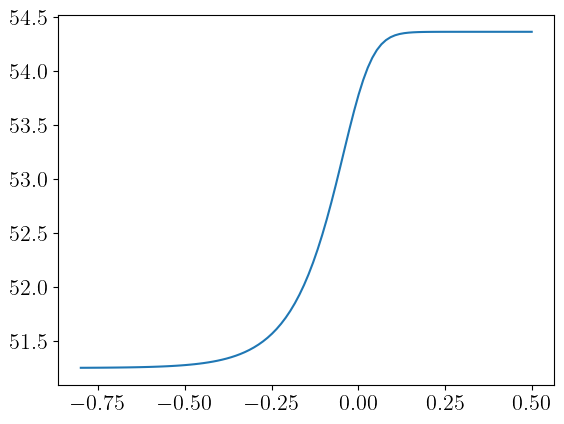

In [51]:
plt.plot(z_range, T_sol)

In [21]:
def moments(Lh):
    npoints = 100
    z_range = np.linspace(-8*Lh, 5*Lh, npoints)
    T_sol = np.zeros((npoints,))
    for i in range(npoints):
        T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tnuc, method='Nelder-Mead', bounds = [(40, 90)])
        if T33min.fun > 0:
            T_sol[i]=T33min.x[0]
        else:
            try:
                s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tnuc)
            except:
                s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tnuc)[0]
            T_sol[i] = s

    hvalues = h_profile(z_range, Lh)
    hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
    d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
    Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
    Ph = np.trapz(- Eh * hprime(z_range), z_range)
    Gh = np.trapz( Eh * hprime(z_range) *(2*h_profile(z_range, Lh)/h0 - 1) , z_range)
    return np.array([Ph, Gh])/1e6

In [24]:
moments(0.12)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_2137/3946513898.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


array([-0.93644095, -0.03956902])

In [41]:
vwlist = [0.4,0.5,0.55]
Tsol_list = []
Ehlist = []
integrand_list = []

In [42]:
for vw in vwlist:
    print("vw = " + str(vw))
    Tm = optimize.newton(lambda T: find_Tsh(T, vw)-Tnuc, Tnuc-1)
    lv_new = mod.findMinimum(lv, Tm)
    vm = vw
    h0 = lv_new

    def h_profile(z, Lh):
        z = np.asanyarray(z)
        hz = 0.5*h0*(1-np.tanh(z/Lh))
        return hz
    c1 = w(Vtot, Tm, lv_new) * vm/(1-vm**2)
    s1=c1
    c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vm**2 /(1-vm**2)
    s2=c2

    def T33(T,z, Lh):
        derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
        field_value = [h_profile(z, Lh)]
        return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6
    
    Lh = 0.1
    npoints = 100
    z_range = np.linspace(-8*Lh, 5*Lh, npoints)
    T_sol = np.zeros((npoints,))
    for i in range(npoints):
        T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tnuc, method='Nelder-Mead', bounds = [(40, 90)])
        if T33min.fun > 0:
            T_sol[i]=T33min.x[0]
        else:
            try:
                s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tnuc)
            except:
                s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tnuc)[0]
            T_sol[i] = s

    Tsol_list.append(T_sol)

    hvalues = h_profile(z_range, Lh)
    hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
    d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
    Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    integrand= - Eh * hprime(z_range)
    Ehlist.append(Eh)
    integrand_list.append(integrand)
    
    

vw = 0.4


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_2137/2177689517.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


vw = 0.5
vw = 0.55


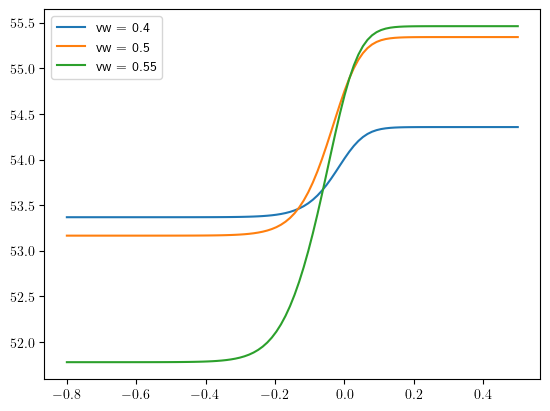

In [43]:
for i in range(3):
    plt.plot(z_range, Tsol_list[i], label=f'vw = {vwlist[i]}')

plt.legend()

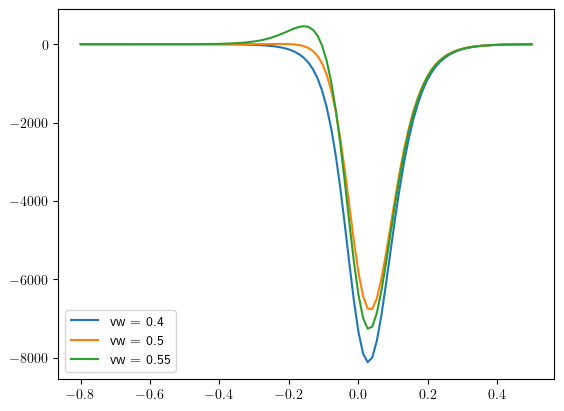

In [39]:
for i in range(3):
    plt.plot(z_range, Ehlist[i], label=f'vw = {vwlist[i]}')

plt.legend()

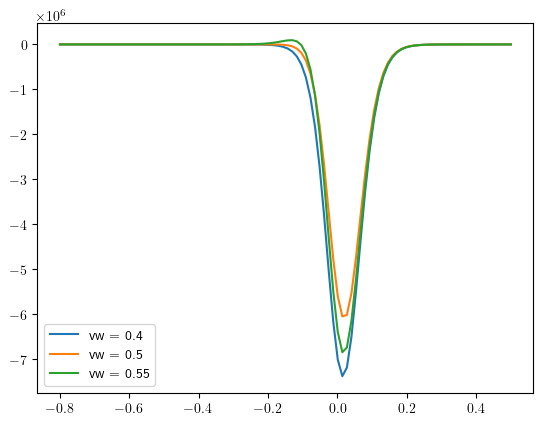

In [40]:
for i in range(3):
    plt.plot(z_range, integrand_list[i], label=f'vw = {vwlist[i]}')

plt.legend()

In [28]:
vwlist = np.linspace(0.1,0.55,10)
Plist = np.zeros((10,))

In [34]:
vwlist = [round(vw,2) for vw in vwlist]

In [29]:
def Ptot(vw):
    print("vw = " + str(vw))
    # Test solution type. Start from deflagration to test.
    Tm = optimize.newton(lambda T: find_Tsh(T, vw)-Tnuc, Tnuc-1)
    lv_new = mod.findMinimum(lv, Tm)
    if cs_sq(Vtot, Tm, lv_new)**0.5 > vw:
        print("Deflagration.")
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
        vm = vw
    else:
        print("Hybrid.")
        Tm = optimize.newton(lambda T: find_Tsh(T, vw, 'hyb')-Tnuc, Tnuc-1)
        lv_new = mod.findMinimum(lv, Tm)
        vm = cs_sq(Vtot, Tm,lv_new)**0.5
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vm,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)


    hv_new = mod.findMinimum(hv, Tp)
    h0 = lv_new

    def h_profile(z, Lh):
        z = np.asanyarray(z)
        hz = 0.5*h0*(1-np.tanh(z/Lh))
        return hz
    c1 = w(Vtot, Tm, lv_new) * vm/(1-vm**2)
    s1=c1
    c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vm**2 /(1-vm**2)
    s2=c2

    def T33(T,z, Lh):
        derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
        field_value = [h_profile(z, Lh)]
        return (0.5*derh**2 - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

    print('T33 prepared.')
    
    def moments(Lh):
        npoints = 100
        z_range = np.linspace(-8*Lh, 5*Lh, npoints)
        T_sol = np.zeros((npoints,))
        for i in range(npoints):
            T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh), Tnuc, method='Nelder-Mead', bounds = [(40, 90)])
            if T33min.fun > 0:
                T_sol[i]=T33min.x[0]
            else:
                try:
                    s = optimize.newton(lambda T: T33(T, z_range[i], Lh), Tnuc)
                except:
                    s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh), Tnuc)[0]
                T_sol[i] = s

        hvalues = h_profile(z_range, Lh)
        hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
        d2zh = np.vectorize(lambda z: (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2)
        Eh = np.array([mod.gradV([hvalues[i]], T_sol[i]) - d2zh(z_range[i])  for i in range(npoints)]).reshape((-1,))
    
        Ph = np.trapz(- Eh * hprime(z_range), z_range)
        Gh = np.trapz( Eh * hprime(z_range) *(2*h_profile(z_range, Lh)/h0 - 1) , z_range)
        return np.array([Ph, Gh])/1e6
    print('Solving moments.')
    Lsol = optimize.newton(lambda L: moments(L)[-1], 0.1)
    print('Moment solved, Lh = ' + str(Lsol))
    P = moments(Lsol)[0]
    return P

In [27]:
Ptot(0.5)

vw = 0.5
Deflagration.
T33 prepared.
Solving moments.


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_2137/1820964711.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


Moment solved, Lh = 0.11978826030726093


-0.7254129755448149

In [35]:
for i in range(len(vwlist)):
    vw = vwlist[i]
    Plist[i] = Ptot(vw)
    print(Plist[i])

vw = 0.1
Deflagration.
T33 prepared.
Solving moments.


/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_2137/1820964711.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_sol[i] = s


Moment solved, Lh = 0.11817690878284817
-1.1397706082998478
vw = 0.15
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11824736478990037
-1.122824157452193
vw = 0.2
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11832164318904198
-1.1004738227952622
vw = 0.25
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11839461429772818
-1.0720945250555207
vw = 0.3
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11846790592054215
-1.0358648885436303
vw = 0.35
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11855776350780627
-0.9880067478649847
vw = 0.4
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.1187258339679181
-0.9208745866989657
vw = 0.45
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11917099074635952
-0.8204077932736993
vw = 0.5
Deflagration.
T33 prepared.
Solving moments.
Moment solved, Lh = 0.11978826030726093
-0.7254129755448149
vw = 0.55
Deflagration.
T3

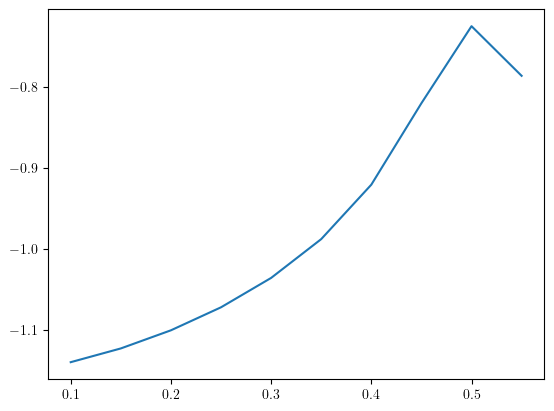

In [36]:
plt.plot(vwlist, Plist)

## Solve entropy vanishing instead of P vanishing

In [44]:
def entropy(V,T, vev):
    v = optimize.fmin(V, vev, args=(T,), disp=0)

    def VT(T):
        return V(v, T)
    
    return -derivative(VT, T, order=1)

In [45]:
def sdiff(vw):
    print("vw = " + str(vw))
    # Test solution type. Start from deflagration to test.
    Tm = optimize.newton(lambda T: find_Tsh(T, vw)-Tnuc, Tnuc-1)
    lv_new = mod.findMinimum(lv, Tm)
    if cs_sq(Vtot, Tm, lv_new)**0.5 > vw:
        print("Deflagration.")
        vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
        vm = vw
    else:
        print("Hybrid.")
        Tm = optimize.newton(lambda T: find_Tsh(T, vw, 'hyb')-Tnuc, Tnuc-1)
        lv_new = mod.findMinimum(lv, Tm)
        vp, Tp = optimize.fsolve(lambda x:match(x[0],cs_sq(Vtot, Tm,lv_new)**0.5,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
        vm = cs_sq(Vtot, Tm,lv_new)**0.5

    lv_new = mod.findMinimum(lv, Tm)

    diff = - Tp/Sqrt(1-vp**2) + Tm/Sqrt(1-vm**2)
    # diff = (- entropy(Vtot, Tp, hv) * vp/Sqrt(1-vp**2) + entropy(Vtot, Tm, lv_new) * vw/Sqrt(1-vw**2))/1e6
    return diff

In [47]:
sdiff(0.5)

vw = 0.5
Deflagration.


-0.108407399705996

In [49]:
vwlist = np.linspace(0.1, 0.55, 10)
vwlist = [round(vw,2) for vw in vwlist]
sdifflist = np.zeros((10,))

In [50]:
for i in range(len(vwlist)):
    sdifflist[i] = sdiff(vwlist[i])
    print(sdifflist[i])

vw = 0.1
Deflagration.
-0.16471355709617796
vw = 0.15
Deflagration.
-0.16271830271620757
vw = 0.2
Deflagration.
-0.16014503228882404
vw = 0.25
Deflagration.
-0.15686929736173738
vw = 0.3
Deflagration.
-0.15254963187091164
vw = 0.35
Deflagration.
-0.14648807837463096
vw = 0.4
Deflagration.
-0.1372949648843118
vw = 0.45
Deflagration.
-0.12248295971903644
vw = 0.5
Deflagration.
-0.108407399705996
vw = 0.55
Deflagration.
-0.1197152879091874


Text(0, 0.5, '$\\Delta (s \\gamma v)$')

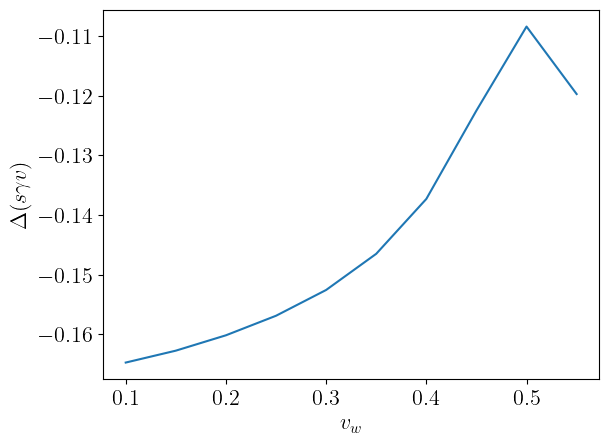

In [51]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')
plt.plot(vwlist, sdifflist)
plt.xlabel(r'$v_w$')
plt.ylabel(r'$\Delta (s \gamma v)$')